In [1]:
pip install pandas numpy matplotlib seaborn scikit-learn tensorflow

Note: you may need to restart the kernel to use updated packages.


In [3]:
import os
import random
import numpy as np
import tensorflow as tf
import pandas as pd

# For data preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# For performance metrics
from sklearn.metrics import (accuracy_score, precision_score, recall_score, 
                           f1_score, roc_auc_score, classification_report, 
                           confusion_matrix)

# For building the neural network
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (Conv1D, MaxPooling1D, Flatten, Dense, Dropout, 
                                   BatchNormalization)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from scikeras.wrappers import KerasClassifier
from sklearn.model_selection import GridSearchCV

# Define a seed value for reproducibility
seed = 42

# Set seeds for reproducibility
os.environ['PYTHONHASHSEED'] = str(seed)
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)


In [4]:
# Read the dataset
data = pd.read_csv('dataset_phishing.csv')

# Define features and target variable
features = ['shortest_word_path', 'ratio_intMedia', 'links_in_tags',
            'nb_hyphens', 'page_rank', 'avg_word_path', 
            'ratio_extHyperlinks', 'longest_words_raw', 'google_index',
            'length_hostname', 'longest_word_host', 
            'domain_registration_length', 'nb_www', 'nb_underscore', 
            'nb_dots', 'ratio_extMedia', 'phish_hints', 'domain_in_title', 
            'web_traffic', 'safe_anchor', 'nb_space', 'shortening_service', 
            'ip', 'domain_age', 'nb_qm', 'nb_hyperlinks', 'nb_slash']

X = data[features]
y = data['status']

# Map the 'status' to numerical labels
label_mapping = {'legitimate': 0, 'phishing': 1}
y = y.map(label_mapping)

# Handle missing values in features if any
X.fillna(0, inplace=True)

# Reshape the data
X_reshaped = X.values

# Perform the split as specified
X_train, X_temp, y_train, y_temp = train_test_split(X_reshaped, y, test_size=0.3, random_state=seed, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=seed, stratify=y_temp)

# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# Reshape for CNN
X_train_cnn = X_train_scaled.reshape(-1, X_train_scaled.shape[1], 1)
X_val_cnn = X_val_scaled.reshape(-1, X_val_scaled.shape[1], 1)
X_test_cnn = X_test_scaled.reshape(-1, X_test_scaled.shape[1], 1)


C:\Users\neo_z\AppData\Local\Temp\ipykernel_30140\3154493124.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X.fillna(0, inplace=True)


In [5]:
def create_model(filters_1=32, kernel_size_1=3, dropout_rate_1=0.2,
                 filters_2=64, kernel_size_2=3, dropout_rate_2=0.2,
                 dense_units=128, learning_rate=0.001):
    model = Sequential()
    
    # First Conv1D layer
    model.add(Conv1D(filters=filters_1, kernel_size=kernel_size_1,
                     activation='relu', input_shape=(X_train_cnn.shape[1], 1),
                     padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling1D(pool_size=2))
    model.add(Dropout(dropout_rate_1))
    
    # Second Conv1D layer
    model.add(Conv1D(filters=filters_2, kernel_size=kernel_size_2,
                     activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling1D(pool_size=2))
    model.add(Dropout(dropout_rate_2))
    
    model.add(Flatten())
    model.add(Dense(dense_units, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dense(1, activation='sigmoid'))
    
    model.compile(optimizer=Adam(learning_rate=learning_rate),
                 loss='binary_crossentropy',
                 metrics=['accuracy', tf.keras.metrics.Recall()])
    
    return model


In [6]:
## For grid search, skip this and run cell below this to use the parameters obtained from previous grid search result.

# Wrap the model
model = KerasClassifier(
    model=create_model,
    verbose=0,
    random_state=seed
)

# Define the grid search parameters
param_grid = {
    'model__filters_1': [32, 64],
    'model__kernel_size_1': [2, 3],
    'model__dropout_rate_1': [0.2, 0.3],
    'model__filters_2': [32, 64],
    'model__kernel_size_2': [2, 3],
    'model__dropout_rate_2': [0.2, 0.3],
    'model__dense_units': [64, 128],
    'model__learning_rate': [0.001, 0.01]
}

# Create GridSearchCV object
grid = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    scoring='recall',
    cv=3,
    n_jobs=-1,
    verbose=2
)

# Fit the grid search
print("Starting Grid Search...")
grid_result = grid.fit(X_train_cnn, y_train)

# Print the best parameters
print("\nBest parameters found:")
# Remove 'model__' prefix from parameter names for clarity
best_params = {k.replace('model__', ''): v for k, v in grid_result.best_params_.items()}
print(best_params)
print("\nBest recall score:", grid_result.best_score_)


Starting Grid Search...
Fitting 3 folds for each of 256 candidates, totalling 768 fits


C:\Users\neo_z\anaconda3\envs\phishing\Lib\site-packages\joblib\externals\loky\process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
C:\Users\neo_z\anaconda3\envs\phishing\Lib\site-packages\numpy\ma\core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,
C:\Users\neo_z\anaconda3\envs\phishing\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



Best parameters found:
{'dense_units': 64, 'dropout_rate_1': 0.2, 'dropout_rate_2': 0.2, 'filters_1': 32, 'filters_2': 64, 'kernel_size_1': 3, 'kernel_size_2': 2, 'learning_rate': 0.01}

Best recall score: 0.8632973460756493


In [12]:
best_params = {'dense_units': 64, 'dropout_rate_1': 0.2, 'dropout_rate_2': 0.2, 'filters_1': 32, 'filters_2': 64, 'kernel_size_1': 3, 'kernel_size_2': 2, 'learning_rate': 0.01}

In [13]:
# Create and train the model with best parameters
print("\nTraining final model with best parameters...")
final_model = create_model(**best_params)

# Early stopping callback
early_stopping = EarlyStopping(monitor='val_recall', patience=5, 
                             restore_best_weights=True, mode='max')

# Train the model
history = final_model.fit(
    X_train_cnn, y_train,
    epochs=50,
    validation_data=(X_val_cnn, y_val),
    callbacks=[early_stopping],
    verbose=1
)



Training final model with best parameters...
Epoch 1/50


C:\Users\neo_z\anaconda3\envs\phishing\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


251/251 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.9045 - loss: 0.2521 - recall_4: 0.9020 - val_accuracy: 0.9341 - val_loss: 0.1798 - val_recall_4: 0.9067
Epoch 2/50
 49/251 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9288 - loss: 0.2075 - recall_4: 0.9096

C:\Users\neo_z\anaconda3\envs\phishing\Lib\site-packages\keras\src\callbacks\early_stopping.py:155: UserWarning: Early stopping conditioned on metric `val_recall` which is not available. Available metrics are: accuracy,loss,recall_4,val_accuracy,val_loss,val_recall_4
  current = self.get_monitor_value(logs)


251/251 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9334 - loss: 0.1841 - recall_4: 0.9250 - val_accuracy: 0.9393 - val_loss: 0.1646 - val_recall_4: 0.9335
Epoch 3/50
251/251 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9397 - loss: 0.1744 - recall_4: 0.9344 - val_accuracy: 0.9457 - val_loss: 0.1542 - val_recall_4: 0.9522
Epoch 4/50
251/251 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9473 - loss: 0.1546 - recall_4: 0.9464 - val_accuracy: 0.9463 - val_loss: 0.1569 - val_recall_4: 0.9393
Epoch 5/50
251/251 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9433 - loss: 0.1490 - recall_4: 0.9388 - val_accuracy: 0.9382 - val_loss: 0.1682 - val_recall_4: 0.9428
Epoch 6/50
251/251 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9428 - loss: 0.1550 - recall_4: 0.9391 - val_accuracy: 0.9492 - val_loss: 0.1529 - val_recall_4: 0.9393
Epoch 7/50
251/251 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9498 - loss: 0.1370 - recall_4: 0.9468 - val_accuracy: 0.9457 - val_loss: 0.1531 - val_recall_4

54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9545 - loss: 0.1696 - recall_4: 0.9565

Test Metrics:
--------------------
Test Accuracy : 0.9569
Test Recall   : 0.9615
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step

Detailed Model Performance Metrics:
----------------------------------------
Accuracy      : 0.9569
Precision     : 0.9526
Recall        : 0.9615
F1 Score      : 0.9570

Confusion Matrix:
--------------------
[[817  41]
 [ 33 824]]

Classification Report:
----------------------------------------
              precision    recall  f1-score   support

           0       0.96      0.95      0.96       858
           1       0.95      0.96      0.96       857

    accuracy                           0.96      1715
   macro avg       0.96      0.96      0.96      1715
weighted avg       0.96      0.96      0.96      1715



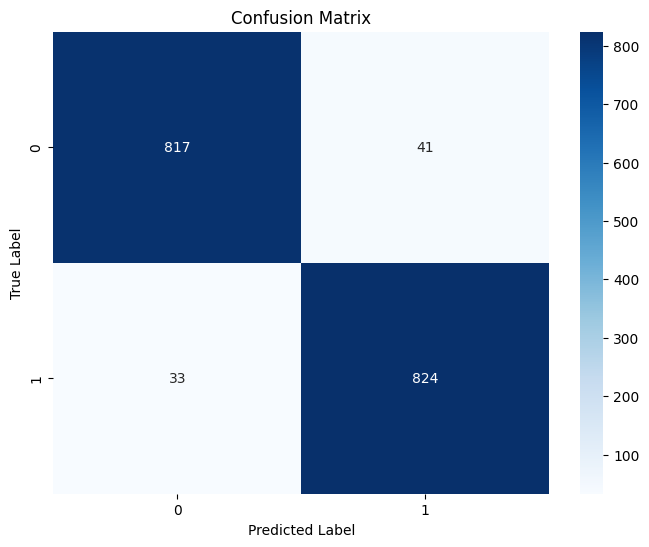

In [15]:
# Evaluate the model on test data
test_loss, test_acc, test_recall = final_model.evaluate(X_test_cnn, y_test)
print('\nTest Metrics:')
print('-' * 20)
print('Test Accuracy : {:.4f}'.format(test_acc))
print('Test Recall   : {:.4f}'.format(test_recall))

# Predict probabilities and classes
y_pred_proba = final_model.predict(X_test_cnn).ravel()
y_pred = (y_pred_proba >= 0.5).astype(int)

# Calculate metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print('\nDetailed Model Performance Metrics:')
print('-' * 40)
print('Accuracy      : {:.4f}'.format(accuracy))
print('Precision     : {:.4f}'.format(precision))
print('Recall        : {:.4f}'.format(recall))
print('F1 Score      : {:.4f}'.format(f1))

# Print confusion matrix
print('\nConfusion Matrix:')
print('-' * 20)
cm = confusion_matrix(y_test, y_pred)
print(cm)

# Print detailed classification report
print('\nClassification Report:')
print('-' * 40)
print(classification_report(y_test, y_pred))

# Visualizations
import matplotlib.pyplot as plt
import seaborn as sns

# Confusion Matrix Heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()